TODO : generaliser à images 32x32, etc.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
#from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32
from waveimage import WaveImage, calc_dim, calc_U, mnist_reshape_32

In [4]:
from scipy.stats import multivariate_normal, entropy

In [5]:
import math

In [6]:
import sys, os

In [7]:
import pickle

In [8]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
from waveimage import calc_U

In [10]:
axes = []
h_max = 6
shape = (32,32)

U = {}
for h in range(h_max):
    U [h] = {}
    dim_i, dim_j = calc_dim(shape, h, h_max)
    for i in range(dim_i):
        for j in range(dim_j):
            U[h][(i,j)] = 1    

NB_POS = len(U[h_max - 1])
print NB_POS

256


## Creation de la base d'apprentissage

In [11]:
def wave_tensor_data(batch_x):
    batch_size, _ = batch_x.shape
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        for h in range(w.get_h_max()):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)]
            else:
                for u in data_h:
                    wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u]
    return wave_tensor

In [12]:
def calc_pow2(i_ref):
    pow2_i = np.zeros(5, dtype='int')
    reste = i_ref
    for p in range(4,-1,-1):
        pow2_i[p] = int(reste // 2**p)
        #reste = reste % 2**p
    return pow2_i[::-1]


In [13]:
print calc_pow2(15)

[ 0  1  3  7 15]


In [14]:
def init_wave_tensor(batch_size):
    wave_tensor = {}
    for h in range(6):
        if h == 0:
            h_size = 1
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 1))
        else:
            h_size = 2**(h - 1)
            wave_tensor[h] = np.zeros((batch_size, h_size, h_size, 3))
    return wave_tensor
    

In [15]:
def wave_tensor_data_backbone(batch_x, depth = -1, i_ref = -1, j_ref = -1):
    batch_size, _ = batch_x.shape
    FLAG_RAND_I = i_ref == -1
    FLAG_RAND_J = j_ref == -1
    FLAG_DEPTH = depth == -1
    wave_tensor = init_wave_tensor(batch_size)
    for num_batch in range(batch_size):
        image = mnist_reshape_32(batch_x[num_batch])
        w = WaveImage(image = image)
        if FLAG_RAND_I:
            i_ref = np.random.randint(16)
        if FLAG_RAND_J:
            j_ref = np.random.randint(16)  
        if FLAG_DEPTH:
            depth = 1 + np.random.randint(6)
        pow2_i = calc_pow2(i_ref)
        pow2_j = calc_pow2(j_ref)
        for h in range(6 - depth, 6):
            data_h = w.get_data()[h]
            if h == 0:
                wave_tensor[h][num_batch][0][0][0] = data_h[(0,0)] #/ 4**4
            else:
                u = (pow2_i[h - 1], pow2_j[h - 1])
                #for u in data_h:
                #    wave_tensor[h][num_batch][u[0]][u[1]][:] = 0
                wave_tensor[h][num_batch][u[0]][u[1]][:] = data_h[u] #/ 4 ** (5 - h)
    return wave_tensor

In [16]:
DEPTH_WAV = 3
NB_LABEL = 10

In [17]:
2 ** 4

16

In [18]:
# Likelihood calculation (over u's, for given v, h and c)

def calc_lik_u(v,h,c):
    h_ref = 5
    '''if h > 0:
        nb_lik = NB_POS / 4 ** (h_ref - h)
        div = 2 ** (h - 1)
    else:
        nb_lik = 1
        div = 1'''
    lik = np.zeros(NB_POS)
    for ind_u in range(NB_POS):
        u_ref = (ind_u / 16, ind_u % 16)
        if h > 0:
            u_path = (u_ref[0] / 2 ** (h_ref - h), u_ref[1] / 2 ** (h_ref - h))
        else:
            u_path = (0, 0)
        if np.linalg.norm(v) < 1e-16:
            if np.linalg.norm(mu[c][h][u_path]) > 1e-16:
                lik[ind_u] = rho[c][h][u_path]
            else:
                lik[ind_u] = 1                
        else:
            if np.linalg.norm(mu[c][h][u_path]) > 1e-16:   
                if h == 0:
                    dist = multivariate_normal(mean = mu[c][h][u_path], cov = Sigma[c][h][u_path])
                else:
                    dist = multivariate_normal(mean = mu[c][h][u_path], cov = Sigma[c][h][u_path] + 1e-10 * np.eye(3))
                lik[ind_u] = (1-rho[c][h][u_path]) * dist.pdf(v)
                #lik[c] =  dist.pdf(v)
            else:
                lik[ind_u] = 0
        lik[ind_u] = max(lik[ind_u],1e-16)    
        #print c, h, u_ref, lik
    return lik

In [19]:
# Log posterior

def update_log_score(log_score, lik):
    #print 'lik =' + str(lik) 
    log_score += np.log(lik) 
    max_log_score = max(log_score)
    log_score -= max_log_score
    return log_score

In [20]:
# Posterior (Softmax)
    
def calc_pi(log_score): # TODO
    Z = np.sum(np.exp(log_score))
    pi = np.exp(log_score)/Z
    #print 'pi =' + str(pi)
    #print 'max(pi) = ',max(pi)
    return pi

# Parcours predictif

In [21]:
mu, Sigma, rho = pickle.load(open("mnist-waveimage-train-mu-Sigma-rho.pkl", "rb"))

In [22]:
pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map.pkl", "rb"))    
#pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "rb"))    

In [23]:
H_generic_eff = pickle.load(open("mnist-waveimage-generic-saliency-map.pkl", "rb"))    
#pi_predictive_eff = pickle.load(open("mnist-waveimage-saliency-map-diff-backbone-CNN-parts.pkl", "rb"))    

In [24]:
def calcule_asc_path(h,u):
    rep = []
    for h_inf in range(h, 0, -1):
        i_inf = u[0] / (2 ** (h - h_inf))
        j_inf = u[1] / (2 ** (h - h_inf))
        rep += [(h_inf, (i_inf, j_inf))]
    # racine
    rep += [(0, (i_inf, j_inf))]
    return rep

In [25]:
def calc_pi_predictive_sorted(pi_predictive): 
    pi_predictive_sorted = {}
    for c in range(10):
        pi_predictive_sorted[c] = []
        for k in pi_predictive[c]:
            pi_predictive_sorted[c] += [(pi_predictive[c][k], k)]
        pi_predictive_sorted[c] = sorted(pi_predictive_sorted[c])
    return pi_predictive_sorted

In [26]:
def calc_H_predictive_sorted(H_predictive): 
    H_predictive_sorted = []
    for k in H_predictive:
        H_predictive_sorted += [(H_predictive[k], k)]
    H_predictive_sorted = sorted(H_predictive_sorted, reverse=True)
    return H_predictive_sorted

In [27]:
def argmax_generator(c, h, u):
    test_pred = rho[c][h][u] < .5       
    if test_pred:
        return mu[c][h][u]
    else:
        return np.zeros(3)

In [28]:
def softmax_generator(log_score, h, u):
    Z = np.sum(np.exp(log_score))
    mu_c = np.zeros(3)
    for c in range(NB_LABEL):
        pi = np.exp(log_score[0][c]) / Z
        mu_c += pi * mu[c][h][u] * (1 - rho[c][h][u])
    return mu_c

In [29]:
h_max = 6
lik_predictive = {}
for c in range(10):
    print c
    lik_predictive[c] = {}
    for h in range(h_max):
        lik_predictive[c][h] = {}
        for u in U[h]:
            v_predictive = argmax_generator(c, h, u)
            lik = calc_lik_u(v_predictive, h, c)
            lik_predictive[c][h][u] = lik

0
1
2
3
4
5
6
7
8
9


In [30]:
def predictive_search_u(u_tilde, log_score, z_actions_set, FLAG_DUAL = False, FLAG_KL = False):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_size = len(z_actions_set)
    #print batch_size
    ## Parcours predictif
    log_score_path = np.zeros((batch_size, NB_POS))
    for i, z_gen in enumerate(z_actions_set):
        log_score_path[i] = np.copy(log_score[0])
    dict_z = {}
    for i, z_gen in enumerate(z_actions_set):
        dict_z[i] = z_gen
        liste_path = calcule_asc_path(h_ref, u_tilde)
        #print(liste_path)
        for (h_path, u_path) in liste_path[:-1]:
            #print(h_path, u_path)
            log_score_path[i] = update_log_score(log_score_path[i], lik_predictive[z_gen][h_path][u_path])
        #print log_score_path[i]
        
    q_pre = np.exp(log_score[0]) / np.sum(np.exp(log_score[0]))
    FEP_post = np.zeros(batch_size)
    for i, z_gen in enumerate(z_actions_set):
        q_post = np.exp(log_score_path[i]) / np.sum(np.exp(log_score_path[i]))  
        if not FLAG_DUAL:
            FEP_post[i] = entropy(q_post)
        else:
            delta_log_score_path = log_score_path[i] - log_score[0]
            delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
            if not FLAG_KL:
                FEP_post[i] = entropy(q_post) - np.log(delta_q_post[u_tilde]) #+ np.log(q_pre[z_ref]) 
            else:
                FEP_post[i] = - np.log(delta_q_post[u_ref])
            #FEP_post[i] = - np.log(delta_q_post[z_ref]) #+ np.log(q_pre[c])
            #print u_gen, entropy(q_post), - np.log(delta_q_post[z_ref]), FEP_post[i] 
                
    #i_max = np.where(log_score_path[:, z_ref] == max(log_score_path[:, z_ref]))[0][0]
    i_min = np.where(FEP_post == min(FEP_post))[0][0]
    q_post = np.exp(log_score_path[i_min]) / np.sum(np.exp(log_score_path[i_min])) 
    delta_log_score_path = log_score_path[i_min] - log_score[0]
    delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
    #print log_score_path[i_min] 
    #print dict_u[i_min] , entropy(q_post), - np.log(delta_q_post[z_ref]) + np.log(q_pre[z_ref]), FEP_post[i_min]
    
    
    ## 3 ##
    return dict_z[i_min] #, pi_path[i_max] #pi_path[i_max][z_ref]
    

In [31]:
def FEP_predictive_search_full(log_score, z_actions_set, FLAG_DUAL = False, FLAG_KL = False):
    # actions_set ne contient que les positions de niveau 5
    h_ref = 5
    batch_ref = len(z_actions_set)
    batch_size = batch_ref * NB_POS
    log_score_path = {}
    
    ## Parcours predictif
    log_score_path = np.zeros((batch_size, NB_POS))
    for i, z_gen in enumerate(z_actions_set):
        for ind_u in range(NB_POS):
            i_full = ind_u * batch_ref + i
            log_score_path[i_full] = np.copy(log_score[0])
    dict_z = {}
    for i, z_gen in enumerate(z_actions_set):
        dict_z[i] = z_gen
        for ind_u, u_gen in enumerate(U[h_ref]):
            liste_path = calcule_asc_path(h_ref, u_gen)
            #print(liste_path)
            for (h_path, u_path) in liste_path[:-1]:
                #print(h_path, u_path)
                    i_full = ind_u * batch_ref + i
                    log_score_path[i_full] = update_log_score(log_score_path[i_full],\
                                                              lik_predictive[z_gen][h_path][u_path])
                        
    FEP_post = np.zeros(batch_size)
    q_pre = np.exp(log_score[0]) / np.sum(np.exp(log_score[0]))
    #print q_pre
    for i, z_gen in enumerate(z_actions_set):
        for ind_u, u_gen in enumerate(U[h_ref]):
            i_full = ind_u * batch_ref + i
            q_post = np.exp(log_score_path[i_full]) / np.sum(np.exp(log_score_path[i_full]))  
            if not FLAG_DUAL:
                FEP_post[i_full] = entropy(q_post)
                #print u_gen, q_post
                #print FEP_post[i]
            else:
                delta_log_score_path = log_score_path[i_full] - log_score[0]
                delta_q_post = np.exp(delta_log_score_path) / np.sum(np.exp(delta_log_score_path))
                #q_pre_hat = np.zeros(NB_LABEL)
                #q_pre_hat[c] = 1
                if not FLAG_KL:
                    FEP_post[i_full] = entropy(q_post) - np.log(delta_q_post[z_gen]) #+ np.log(q_pre[c])
                else:
                    FEP_post[i_full] = - np.log(delta_q_post[z_gen]) 
                #FEP_post[i_full] = - np.log(delta_q_post[c]) #+ np.log(q_pre[c])
                #FEP_post[i_full] = entropy(q_post) + entropy(q_pre, delta_q_post)
                #print u_gen, entropy(q_post), - np.log(delta_q_post[c]), FEP_post[i_full] 
    #ch = raw_input('')        
    FEP_post_full = np.zeros((batch_ref,))
    for ind_u in range(NB_POS):
        FEP_post_full += q_pre[ind_u] * FEP_post[ind_u * batch_ref : (ind_u + 1) * batch_ref]
        
    #for i, u_gen in enumerate(actions_set):
    #    print u_gen, FEP_post_full[i]
    
    i_min = np.where(FEP_post_full == min(FEP_post_full))[0][0]
    
    ## 3 ##
    return dict_z[i_min]  #pi_path[i_max][z_ref]
    

In [89]:
def prediction_based_policy(log_score, z_actions_set, FLAG_DUAL = False, FLAG_KL = False):
    
    u_tilde = np.argmax(log_score)    
    z_tilde = predictive_search(u_tilde, log_score, z_actions_set, FLAG_DUAL, FLAG_KL)
    
    return z_tilde

In [32]:
def FEP_prediction_based_policy(log_score, z_actions_set, FLAG_DUAL = False, FLAG_KL = False):
    
    z_tilde = FEP_predictive_search_full(log_score, z_actions_set, FLAG_DUAL, FLAG_KL)
    
    return z_tilde

In [33]:
def random_policy(log_score, z_actions_set):
    h = 5
    ## 1 ##
    u_tilde = np.argmax(log_score)
    #u_tilde = (1 + np.random.randint(14),  1 + np.random.randint(14))
    dict_z = {}
    for i, z_gen in enumerate(z_actions_set):
        dict_z[i] = z_gen
    z_tilde = dict_z[np.random.randint(len(dict_z))]
    return z_tilde

In [92]:
def scene_exploration(wave_tensor_ref, log_score, u_ref, ind_test, z_actions_set, record, \
                      POL = 'FEP-predictive', AFF = True, THRESHOLD = 1e-4):
    
    assert  POL == 'random' or POL == 'full'\
    or POL == 'FEP-predictive' or POL == 'FEP-predictive-dual'
    
    if POL == 'full':
        THRESHOLD = 0
        POL = 'saliency-based'
    
    TOUR = 0
    END = False
    h_ref = 5
    
    # saliency-based approach

    while END == False:
        if AFF:
            print '************************************'
            print '******       TOUR    ' + str(TOUR + 1) + '        ******'
            print '************************************'
        
        # 1. CHOIX
        if POL == 'FEP-predictive-dual':
            z_tilde = TOUR #FEP_prediction_based_policy(log_score, z_actions_set,\
                           #                           FLAG_DUAL = True)
            #ch = raw_input('')     
        elif POL == 'FEP-predictive':
            z_tilde = TOUR #FEP_prediction_based_policy(log_score, z_actions_set,\
                           #                           FLAG_DUAL = False)
        else:
            z_tilde = random_policy(log_score, z_actions_set)
        
        if AFF:
            print 'CHOIX :', z_tilde
        
        # 2. LECTURE + UPDATE
        #wave_tensor =  init_wave_tensor(1)
        liste_path = calcule_asc_path(h_ref, u_ref)
        ## ! ##
        mem_z_tilde = z_tilde
        
        for (h_path, u_path) in reversed(liste_path):
          ## ! ##  
          for z_tilde in range(10):
            ## ! ##  
            v = wave_tensor_ref[h_path][mem_z_tilde][u_path[0]][u_path[1]][:]
            lik = calc_lik_u(v, h_path, z_tilde)
            log_score[0] = update_log_score(log_score[0], lik)
            #wave_tensor[h_path][0][u_path[0]][u_path[1]][:] =  
            record.nb_coeffs += 3  
            
        ## ! ##    
        z_tilde = mem_z_tilde
        log_score[0] /= 10
                
        pi = np.exp(log_score[0]) / np.sum(np.exp(log_score[0])) #sess.run(tf.nn.softmax(log_score))[0]
                
        H = entropy(pi) # sess.run(tf.nn.softmax_cross_entropy_with_logits(labels=pi,logits=log_score)) #np.sum(- pi * np.log(pi))
        out = np.argmax(pi)
        out_i = out / 16
        out_j = out % 16
                
        if AFF :
            #print 'pi : ', pi
            print 'out :', out,  (out_i, out_j)
            print 'pi[out] : ', pi[out]
            print 'H : ', H

        record.mem_pi += [pi]
        record.mem_H += [H]
        record.mem_u += [(out_i, out_j)]
                
        # 3. INHIBITION OF RETURN        
        z_actions_set.pop(z_tilde)
        
        record.mem_z += [z_tilde]
        record.nb_saccades += 1
                
        if AFF:
            print '****', 'u :', u_ref, ', z :',z_tilde, ' ---> ', (out_i, out_j)
              
        ## ! ##
        if TOUR == 1: #NB_LABEL - 1  :#or H < THRESHOLD:
            END = True
            if AFF :
                print '************************************'
                print '******         FINI          *******'
                print '************************************' 
            return (out_i, out_j)
        else:
            TOUR += 1   

## Main

In [35]:
from record import Record, affiche_records            

In [36]:
NB_TRIALS = 1

In [37]:
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [38]:
# Test generic saliency map

In [39]:
Data_test = [[],[],[],[],[],[],[],[],[],[]]
for i in range(len(mnist.test.images)):
    c = mnist.train.labels[i]
    Data_test[c] += [mnist.train.images[i]]

In [96]:
import time
dict_records = {}

#file_name = "mnist-waveimage-CNN-backbone-records-rnd-parts-generic-saliency.npy"
file_name = "mnist-waveimage-records-FEP-inverse-control.npy"

if True: # not os.path.isfile(file_name):
    
    for POL in ('FEP-predictive-dual',): # 'FEP-predictive', 'random'): # 'FEP-predictive'): #'generic-saliency-based',): 

        dict_records[POL] = {}

        for THRESHOLD in (1e-1,):#, 1e-2, 1e-3):

            records = [] 
            cpt_TRIALS = 0

            tic = time.time()

            #NB_TRIALS = len(Data_test[z_ref][0][(0,0)])

            for ind_test in range(NB_TRIALS):
                if ind_test % 10 == 0:
                    print(POL, THRESHOLD, ind_test)

                batch_x = np.zeros((10, 28 * 28))
                for c in range(10):
                    x_test = Data_test[c][ind_test]
                    batch_x[c,:] = x_test
                wave_tensor_ref = wave_tensor_data(batch_x)
                u_ref = (np.random.randint(16), np.random.randint(16))
                # + 0.1 * np.random.randn(28 * 28)
                # 
                # initial
                log_score = np.zeros((1,NB_POS))
                pi = np.ones(NB_POS) / NB_POS
                H = entropy(pi) #np.sum(- pi * np.log(pi))

                record = Record()
                record.POL = POL
                record.THRESHOLD = THRESHOLD
                record.u_ref = u_ref
                record.mem_pi += [pi]
                record.mem_H += [H]
                u_tilde = -1

                # global coef --> log_score initial
                '''mem_h_u = [(0, (0, 0)), (1, (0, 0))]
                h, u = 0, (0, 0)
                v = wave_tensor_ref[h][0][u[0]][u[1]][:]
                lik = calc_lik(v,h,u)
                log_score = update_log_score(log_score, lik)
                h, u = 1, (0, 0)
                v = wave_tensor_ref[h][0][u[0]][u[1]][:]
                lik = calc_lik(v,h,u)
                log_score = update_log_score(log_score, lik)
                pi = calc_pi(log_score)
                H = entropy(pi) #np.sum(- pi * np.log(pi))
                z_tilde = np.argmax(log_score)

                record.mem_pi += [pi]
                record.mem_H += [H]
                record.mem_z += [z_tilde]
                record.nb_coeffs += 1'''

                # initial actions set
                z_actions_set = {}
                for c in range(NB_LABEL):
                    z_actions_set[c] = 1

                u_final = scene_exploration(wave_tensor_ref, log_score, u_ref, ind_test,\
                                            z_actions_set, record, \
                                            POL = POL, AFF = True, THRESHOLD = THRESHOLD)
                record.u_final = u_final
                record.success = u_ref == u_final

                records += [record]

                toc = time.time()
                if NB_TRIALS <= 1000:
                    print '\rPolicy : %s, threshold : %g, %d saccades, final : (%d, %d), classe : (%d, %d), elapsed time : %g' \
                                    % (POL, THRESHOLD, record.nb_saccades, u_final[0], u_final[1], u_ref[0], u_ref[1], toc - tic)   
                cpt_TRIALS  += NB_TRIALS

            dict_records[POL][THRESHOLD] = records
            print '\n'
            print 'Nb trials :', cpt_TRIALS
            #affiche_records(records)
            print '\n'
            np.save(file_name, dict_records)
else:
    dict_records = np.load(file_name)
        

('FEP-predictive-dual', 0.1, 0)
************************************
******       TOUR    1        ******
************************************
CHOIX : 0
out : 130 (8, 2)
pi[out] :  0.162899406246
H :  2.1977003149
**** u : (9, 2) , z : 0  --->  (8, 2)
************************************
******       TOUR    2        ******
************************************
CHOIX : 1
out : 130 (8, 2)
pi[out] :  0.130588722682
H :  2.39765620318
**** u : (9, 2) , z : 1  --->  (8, 2)
************************************
******         FINI          *******
************************************
Policy : FEP-predictive-dual, threshold : 0.1, 2 saccades, final : (8, 2), classe : (9, 2), elapsed time : 4.08801


Nb trials : 1




Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 7, classe : 7, elapsed time : 0.290342
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 6, classe : 2, elapsed time : 0.443286
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 0.587564
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 0, classe : 0, elapsed time : 0.736176
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 0.991568
Policy : FEP-predictive, threshold : 0.1, 1 saccades, initial : -1, final : 1, classe : 1, elapsed time : 1.14426
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 4, classe : 4, elapsed time : 1.446
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 9, classe : 9, elapsed time : 1.69376
Policy : FEP-predictive, threshold : 0.1, 2 saccades, initial : -1, final : 6, classe : 5, elapsed time : 1.95663
Policy : FEP-predictive, threshold : 0.1, 3 saccades, initial : -1, final : 9, classe : 9, elapsed time : 2.32355

## Main Backup

In [66]:
u_ref

(2, 14)

In [67]:
u_final

(0, 14)

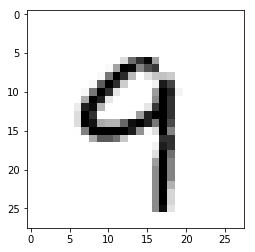

In [45]:
plt.imshow(x_test.reshape((28, 28)), cmap = 'gray_r')

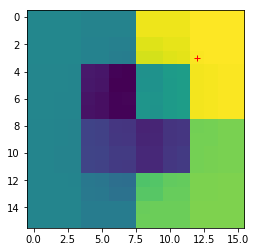

In [94]:
plt.imshow(log_score.reshape((16,16)))
plt.plot(u_ref[1], u_ref[0], 'r+')

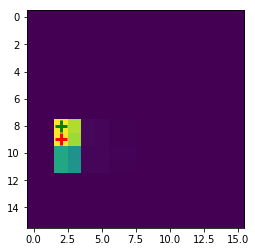

In [97]:
for i in range(1,2):
    plt.figure()
    plt.imshow(record.mem_pi[i].reshape((16,16)))
    out = np.argmax(record.mem_pi[i])
    out_i = out / 16
    out_j = out % 16
    plt.plot(u_ref[1], u_ref[0], 'r+',markersize=12, mew = 3)
    plt.plot(out_j, out_i, 'g+',markersize=12, mew = 3)
    plt.savefig('FEP-inv-control-1')

In [55]:
record.mem_pi

[array([ 0.00390625,  0.00390625,  0.00390625,  0.00390625,  0.00390625,
         0.00390625,  0.00390625,  0.00390625,  0.00390625,  0.00390625,
         0.00390625,  0.00390625,  0.00390625,  0.00390625,  0.00390625,
         0.00390625,  0.00390625,  0.00390625,  0.00390625,  0.00390625,
         0.00390625,  0.00390625,  0.00390625,  0.00390625,  0.00390625,
         0.00390625,  0.00390625,  0.00390625,  0.00390625,  0.00390625,
         0.00390625,  0.00390625,  0.00390625,  0.00390625,  0.00390625,
         0.00390625,  0.00390625,  0.00390625,  0.00390625,  0.00390625,
         0.00390625,  0.00390625,  0.00390625,  0.00390625,  0.00390625,
         0.00390625,  0.00390625,  0.00390625,  0.00390625,  0.00390625,
         0.00390625,  0.00390625,  0.00390625,  0.00390625,  0.00390625,
         0.00390625,  0.00390625,  0.00390625,  0.00390625,  0.00390625,
         0.00390625,  0.00390625,  0.00390625,  0.00390625,  0.00390625,
         0.00390625,  0.00390625,  0.00390625,  0.0